I've been working on building a Bayesian model to infer the firing rate of neurons over time. Python has a few packages available which use [Markov Chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) (MCMC) methods to sample from the posterior distribution of a Bayesian model. The one I'm most familiar with is [PyMC](https://github.com/pymc-devs/pymc3), the newest version (PyMC3) implements the [No-U-Turn Sampler](http://arxiv.org/abs/1111.4246) (NUTS) developed by Matthew Hoffman and Andrew Gelman. NUTS is based on Hamiltonian MCMC which uses the gradient of the posterior log probability to avoid the random walk nature of Metropolis-Hastings samplers, but requires very little tuning by the user. In the new version, the authors of PyMC chose to use [Theano](http://deeplearning.net/software/theano/) to calculate the log-p gradients. This is where I ran into problems.

Theano requires a very non-Pythonic semantic and syntactic style to build models. Something that would have taken me minutes writing normal Python, took me hours trying to get it to work with Theano. A bit later I was discussing my issues with my friend Andy when he suggested there should be a sampler implementation where you can simply pass a normal Python function calculating $\log P(\theta)$ into the samplers.

After a couple hours thinking up the name, I started writing [Sampyl](https://github.com/mcleonard/sampyl), a new package implementing MCMC samplers. The main feature is that each sampler takes a $\log P(\theta)$ function for whatever distribution you want to draw from. It uses [Autograd](https://github.com/HIPS/autograd) for automatic gradient calculations, but it is not required. I have written a nice [example notebook](http://nbviewer.ipython.org/github/mcleonard/sampyl/blob/master/Examples.ipynb) for Sampyl, but here I will use it to analyze some fake A/B testing data.

<!-- fold -->

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn
import scipy.stats as stats
from scipy.misc import comb
import scipy as sp

import sampyl as smp
from sampyl import np

In [3]:
seaborn.set_context("notebook", font_scale=1.25)

## A/B testing


Many businesses with websites perform large scale experiments on their users aimed at improving revenue or user retention. Commonly, users visiting the website are split between two versions, A and B, which might have different user interfaces, placement of advertisements, or content. Then, we'd want to know if the new design (B) is better than the old one (A) according to some metric such as the proportion of users who click through to the next page and sign up for the service.

Suppose we want to know if there is a statistically significant difference in the click through rate between versions A and B. To answer this, we can build a simple Bayesian model. Bayesian data analysis utilizes Bayes' theorem to infer the distribution of parameters given observed data. Bayes' theorem is fairly simple,

$$ P( \theta \mid D) \propto P(D \mid \theta) \, P(\theta), $$

or in words, the probability distribution of parameters $\theta$ given your data $D$ is proportional to the likelihood $P(D \mid \theta)$ of seeing data $D$ given parameters $\theta$ and your prior beliefs about $\theta$, $P(\theta)$. The distribution $P( \theta \mid D)$ is called the posterior because it represents your beliefs about $\theta$ *after* seeing the data $D$, while $P(\theta)$ is called the prior because it represents beliefs *before* seeing data.

This expression in mathematics is very similar to how humans think. Typically you have initial beliefs about a claim, this is represented by $P(\theta)$. For instance, suppose you think your new haircut is amazing. Then at work you get a lot of complements, which of course is highly likely according to your beliefs. Now you believe even more strongly that you have the best hair ever cut in the history of the world, because everyone said so.

We can apply this framework to build a model for A/B testing which will tell us if B is better than A or not.  The model is built like so, where $p$ is the proportial of users who click through:

\begin{align}
P(p \mid D) &\propto P(D \mid p)\, P(p) \\
P(D \mid p) &\sim \mathrm{Binomial}(D \mid p) \\
P(p) &\sim \mathrm{Beta}(\alpha, \beta) \\
\end{align}

We can the likelihood $P(D \mid p)$ by thinking of how we would generate data. The binomial distribution describes how many successes you would see in some number of attempts, given a probability of success. Tossing coins is described by a binomial distribution, where $p = \frac{1}{2}$ for a fair coin. So, our data is the number of people who click through (the number of coins ending heads up) given the total number of people seeing the page (total number of coin flips), with some probability that any given person will click through.

Our prior beliefs about this probability can be captured by the [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution). The beta distribution is defined only between 0 and 1, just like $p$, and by setting $\alpha$ and $\beta$ appropriately, we can express our beliefs about possible values for $p$. For instance, we know from past experience that the click through rate is always around $p = 0.1$, so it wouldn't make sense for us to include much probability that $p > 0.5$, for instance we could chose this:

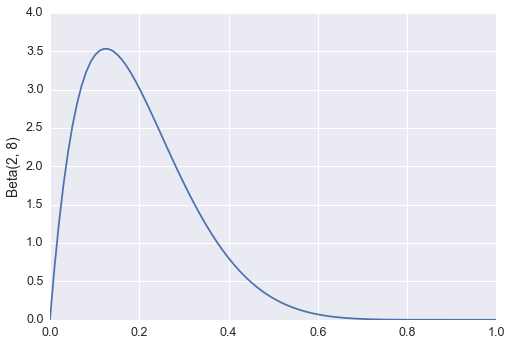

In [99]:
x = np.linspace(0, 1, 100)
plt.plot(x, sp.stats.beta(2, 8).pdf(x))
plt.ylabel("Beta(2, 8)")

## Building a model

Now I'm going to construct a function that calculates $\log P(p \mid D)$ and sample from it with sampyl. But first, I'll need to construct some fake data, where B will have an additional 1% click through rate.

In [67]:
N = 1000  # Users in experiment
A = np.random.binomial(N, 0.10)
B = np.random.binomial(N, 0.11)

In [68]:
from sampyl.priors import bound

In [90]:
alpha, beta = 2, 8
def logp(pA, pB):
    # Likelihoods for A and B
    likelihood = lambda x, px: bound(x*np.log(px) + 
                                     (N - x)*np.log(1 - px),
                                     0 < px < 1)
    likelihood_A = likelihood(A, pA)
    likelihood_B = likelihood(B, pB)
    
    # Beta priors over A and B
    beta_prior = lambda px: bound((alpha - 1)*np.log(px) + 
                                  (beta - 1)*np.log(1 - px),
                                  0 < px < 1)
    prior_A = beta_prior(pA)
    prior_B = beta_prior(pB)
    
    return likelihood_A + likelihood_B + prior_A + prior_B

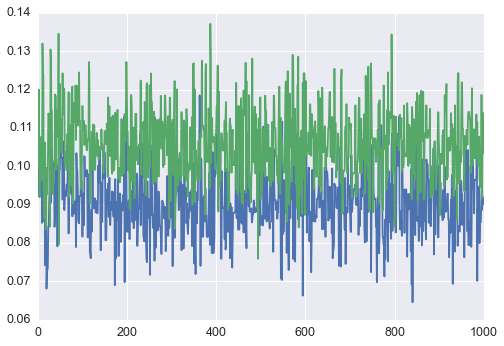

In [92]:
nuts = smp.NUTS(logp, start={'pA': 0.1, 'pB': 0.1})
trace = nuts.sample(1000)
plt.plot(trace.pA)
plt.plot(trace.pB)

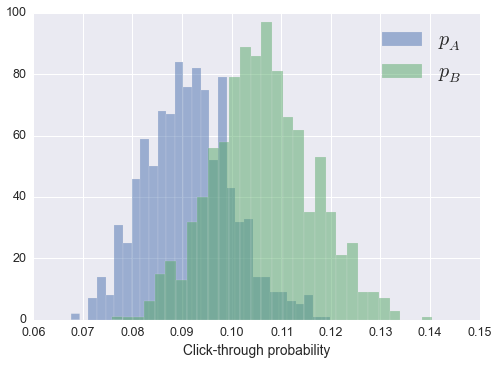

In [104]:
plt.hist(trace.pA, bins=30, alpha=.5, label='$p_A$')
_ = plt.hist(trace.pB, bins=30, alpha=.5, label='$p_B$')
plt.legend(fontsize=20)
plt.xlabel('Click-through probability')

Now that we have estimates for $p_A$ and $p_B$, we can calculate a probability that $p_B > p_A$. Simply, we'll find the difference, $\delta = p_B - p_A$, then measure the proportion of samples where $\delta > 0$.

Probability that p_B > p_A = 0.871


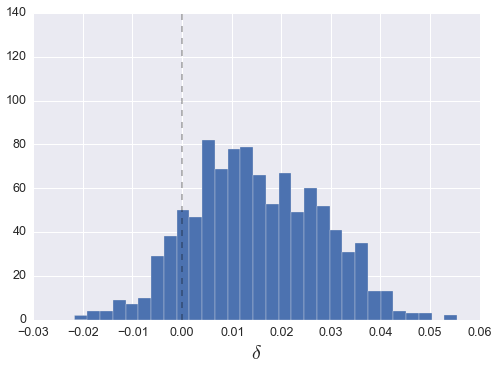

In [94]:
delta = trace.pB - trace.pA
_ = plt.hist(delta, bins=30)
plt.vlines(0, 0, 140, linestyles='--', alpha=0.3)
_ = plt.xlabel('$\delta$', size=20)
print("Probability that p_B > p_A = {}".format((delta > 0).mean()))

This is just under what we would typically call significant. It is important to note that our result is different than the p-value you get from hypothesis testing. For our Bayesian estimation here, we literally are calculating the probability that $p_B > p_A$, based solely on our data and our previous knowledge of the problem. However, with hypothesis testing, $p$ is the probability that you would see a result at least as extreme as the one you found if you repeated the experiment infinite times. If you want more to read about Bayesian data analysis, I suggest [this great series](https://jakevdp.github.io/blog/2014/03/11/frequentism-and-bayesianism-a-practical-intro/) by Jake VanderPlas.